<a href="https://colab.research.google.com/github/bobbercheng/ventilator-pressure-prediction/blob/master/ventilator_gb_rescaling_V12_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

V1: Keep R/C, improve

V2: Add R**2, no improve

V3: Update model from https://www.kaggle.com/dlaststark/gb-vpp-pulp-fiction. Not much improve compare V1

V4: Use whole db for test Fold-1
Fold-1 | OOF Score: 0.15912771348961205

Run it again in Kaggle:

Fold-1 | OOF Score: 0.1606402072946816

V5: Add loading ScaleLayer from saved model

V6: Add TransformerEncoder. TransformerEncoder(128, 512, 8, name="transformer_layer")(x). Testing in GPU.

V7: Try to scale targe to 0-1, but it slow the train as MASE cannot be scaled.

V8: Removed target scale.
Epoch 00022: val_loss improved from 0.32912 to 0.30967, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 23/150
127/127 [==============================] - 161s 1s/step - loss: 0.3176 - val_loss: 0.2917

Not Good as without TransformerEncoder. Change paramemter back to 

V8: Change attention result to multiple instead of concate.

Loss is smaller than without LayerNormalization, but CV is bigger. It means it overfit the train data.

TransformerEncoder(128, 512, 8, 0.3, name="transformer_layer")

Epoch 00181: val_loss did not improve from 0.16212
Epoch 182/200
127/127 [==============================] - 163s 1s/step - loss: 0.0448 - val_loss: 0.1655

Epoch 00182: ReduceLROnPlateau reducing learning rate to 5.6313510867767036e-05.

Epoch 00182: val_loss did not improve from 0.16212
Restoring model weights from the end of the best epoch.
Epoch 00182: early stopping
Fold-1 | OOF Score: 0.16211654680482343

V9: Increase attention dropout to 0.6, add 0.01 droupout to input
Epoch 00123: ReduceLROnPlateau reducing learning rate to 0.00031640623637940735.

Epoch 00123: val_loss did not improve from 0.16714
Epoch 124/200
127/127 - 161s - loss: 0.0838 - val_loss: 0.1694

Epoch 00124: val_loss did not improve from 0.16714
Epoch 125/200
127/127 - 161s - loss: 0.0796 - val_loss: 0.1727

V10: add TransformerEncoder to all layer with Multiply

Epoch 164/200
253/253 - 387s - loss: 0.0568 - val_loss: 0.1679

Epoch 00164: val_loss did not improve from 0.16158
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
Fold-1 | OOF Score: 0.16158229343436334

V10: analy_predict.

Here is analyze result for V4:
20__10 - MAE  0.16386306650915122, count: 25870
20__20 - MAE  0.15764106283234391, count: 26272
20__50 - MAE  0.16384391190488698, count: 34729
50__10 - MAE  0.1585241009544335, count: 60574
50__20 - MAE  0.24078390163257296, count: 37108
50__50 - MAE  0.23760641023725088, count: 34699
5__10 - MAE  0.15540978004136713, count: 36361
5__20 - MAE  0.10102388763185534, count: 35935
5__50 - MAE  0.11535413256937187, count: 35522


V11: add dnn_model_GaussianNoise(), no improve

Epoch 00183: val_loss did not improve from 0.16240
Epoch 184/200
127/127 - 150s - loss: 0.0498 - val_loss: 0.1642

Epoch 00184: ReduceLROnPlateau reducing learning rate to 7.508467933803331e-05.

Epoch 00184: val_loss did not improve from 0.16240
Restoring model weights from the end of the best epoch.
Epoch 00184: early stopping
Fold-1 | OOF Score: 0.16240143234043636

V12: dnn_model_aen(), use auto encoder to remove noise and learn encode.


In [1]:
# Update pandas version for Colab TPU
!pip install pandas==1.3.2

## Import libraries

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
  from google.colab import drive
  drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [4]:
if IN_COLAB:
  !pip install kaggle
  !mkdir /root/.kaggle
  !cp /gdrive/MyDrive/ventilator-pressure-prediction/kaggle.json /root/.kaggle
  !kaggle competitions download -c ventilator-pressure-prediction
  !mkdir -p ../input/ventilator-pressure-prediction
  !unzip '*.zip' -d ../input/ventilator-pressure-prediction
  !ls ../input/ventilator-pressure-prediction
  !mkdir /gdrive/MyDrive/ventilator-pressure-prediction/gb-rescaling-eda-v3-gpu
  #Map Google driver folder to local folder model to save model
  !ln -s /gdrive/MyDrive/ventilator-pressure-prediction/gb-rescaling-eda-v3-gpu model-gpu
else:
  !mkdir ./model-gpu

 74% 56.0M/75.4M [00:00<00:00, 64.0MB/s]
100% 75.4M/75.4M [00:00<00:00, 129MB/s] 
 86% 120M/139M [00:00<00:00, 244MB/s] 
100% 139M/139M [00:00<00:00, 237MB/s]
 94% 8.00M/8.50M [00:00<00:00, 83.7MB/s]
100% 8.50M/8.50M [00:00<00:00, 78.3MB/s]
Archive:  train.csv.zip
  inflating: ../input/ventilator-pressure-prediction/train.csv  

Archive:  sample_submission.csv.zip
  inflating: ../input/ventilator-pressure-prediction/sample_submission.csv  

Archive:  test.csv.zip
  inflating: ../input/ventilator-pressure-prediction/test.csv  

3 archives were successfully processed.
sample_submission.csv  test.csv  train.csv
mkdir: cannot create directory ‘/gdrive/MyDrive/ventilator-pressure-prediction/gb-rescaling-eda-v3-gpu’: File exists


In [5]:
import gc
import numpy as np
import pandas as pd
import random
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply



# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything()

## Load datasets

In [6]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
print(f"train_df: {train_df.shape}")
train_df.head()

train_df: (6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
all_pressure = np.sort(train_df['pressure'].unique())
pressure_min =  all_pressure[0].item()
pressure_max = all_pressure[-1].item()
pressure_step = (all_pressure[1] - all_pressure[0]).item()

pressure_min,pressure_max,pressure_step

(-1.895744294564641, 64.8209917386395, 0.07030214545121005)

In [8]:
DEBUG = False

if DEBUG:
    train_df = train_df[:80*10000]

In [9]:
test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
print(f"test_df: {test_df.shape}")
test_df.head()

test_df: (4024000, 7)


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


## Feature Engineering

In [10]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    #df['u_in_diff_1_2'] = df['u_in_lag1'] - df['u_in_lag2']
    #df['u_out_diff_1_2'] = df['u_out_lag1'] - df['u_out_lag2']
    #df['u_in_lagback_diff_1_2'] = df['u_in_lag_back1'] - df['u_in_lag_back2']
    #df['u_out_lagback_diff_1_2'] = df['u_out_lag_back1'] - df['u_out_lag_back2']
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R_cat'] = df['R'].astype(str)
    df['C_cat'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df


print("Train data...\n")
train = add_features(train_df)

print("\nTest data...\n")
test = add_features(test_df)

Train data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed

Test data...

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [11]:
del train_df
del test_df
gc.collect()

50

In [12]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count','breath_id_lag',
                  'breath_id_lag2','breath_id_lagsame',
                  'breath_id_lag2same'], axis=1)

print(f"train: {train.shape} \ntest: {test.shape}")

train: (6036000, 66) 
test: (4024000, 66)


In [13]:
train.head()

,R,C,time_step,u_in,u_out,cross,cross2,area,time_step_cumsum,u_in_cumsum,u_in_lag1,u_out_lag1,u_in_lag_back1,u_out_lag_back1,u_in_lag2,u_out_lag2,u_in_lag_back2,u_out_lag_back2,u_in_lag3,u_out_lag3,u_in_lag_back3,u_out_lag_back3,u_in_lag4,u_out_lag4,u_in_lag_back4,u_out_lag_back4,breath_id__u_in__max,breath_id__u_out__max,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_diff1,u_out_diff1,u_in_diff2,u_out_diff2,u_in_diff3,u_out_diff3,u_in_diff4,u_out_diff4,u_in_cummean,breath_id__u_in_lag,breath_id__u_in_lag2,time_step_diff,ewm_u_in_mean,15_in_sum,15_in_min,15_in_max,15_in_mean,u_in_lagback_diff1,u_out_lagback_diff1,u_in_lagback_diff2,u_out_lagback_diff2,R_cat_20,R_cat_5,R_cat_50,C_cat_10,C_cat_20,C_cat_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,20,50,0.000000,0.083334,0,0.0,0.0,0.000000,0.000000,0.083334,0.000000,0.0,18.383041,0.0,0.000000,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,28.313036,1,28.229702,10.062673,0.083334,0.0,0.083334,0.0,0.083334,0.0,0.083334,0.0,0.083334,0.000000,0.000000,0.000000,0.083334,0.083334,0.083334,0.083334,0.083334,-18.299707,0.0,-22.425944,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,20,50,0.033652,18.383041,0,0.0,0.0,0.618632,0.033652,18.466375,0.083334,0.0,22.509278,0.0,0.000000,0.0,22.808822,0.0,0.000000,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,28.313036,1,9.929994,-8.237035,18.299707,0.0,18.383041,0.0,18.383041,0.0,18.383041,0.0,9.233188,0.083334,0.000000,0.033652,9.585358,18.466375,0.083334,18.383041,9.233188,-4.126236,0.0,-4.425781,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,20,50,0.067514,22.509278,0,0.0,0.0,2.138333,0.101167,40.975653,18.383041,0.0,22.808822,0.0,0.083334,0.0,25.355850,0.0,0.000000,0.0,27.259866,0.0,0.000000,0.0,27.127486,0.0,28.313036,1,5.803758,-12.363271,4.126236,0.0,22.425944,0.0,22.509278,0.0,22.509278,0.0,13.658551,18.383041,0.083334,0.033862,14.229040,40.975653,0.083334,22.509278,13.658551,-0.299544,0.0,-2.846573,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,20,50,0.101542,22.808822,0,0.0,0.0,4.454391,0.202709,63.784476,22.509278,0.0,25.355850,0.0,18.383041,0.0,27.259866,0.0,0.083334,0.0,27.127486,0.0,0.000000,0.0,26.807732,0.0,28.313036,1,5.504214,-12.662816,0.299544,0.0,4.425781,0.0,22.725488,0.0,22.808822,0.0,15.946119,22.509278,18.383041,0.034028,16.627759,63.784476,0.083334,22.808822,15.946119,-2.547028,0.0,-4.451044,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,20,50,0.135756,25.355850,0,0.0,0.0,7.896588,0.338464,89.140326,22.808822,0.0,27.259866,0.0,22.509278,0.0,27.127486,0.0,18.383041,0.0,26.807732,0.0,0.083334,0.0,27.864715,0.0,28.313036,1,2.957185,-15.209844,2.547028,0.0,2.846573,0.0,6.972809,0.0,25.272516,0.0,17.828065,22.808822,22.509278,0.034213,18.652046,89.140326,0.083334,25.355850,17.828065,-1.904016,0.0,-1.771635,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [14]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

print(f"train: {train.shape} \ntest: {test.shape} \ntargets: {targets.shape}")

train: (75450, 80, 66) 
test: (50300, 80, 66) 
targets: (75450, 80)


In [15]:
train[:3, 0, :]

array([[ 0.00000000e+00,  7.50000000e-01, -9.89052161e-01,
        -9.37384450e-01, -1.00000000e+00,  0.00000000e+00,
        -6.65541311e-01, -5.16580501e-01, -4.96657632e-01,
        -7.25227791e-01, -8.64120606e-01, -1.00000000e+00,
         2.89020724e+00, -1.00000000e+00, -8.42526591e-01,
        -1.00000000e+00,  3.66402550e+00, -1.00000000e+00,
        -8.19257888e-01, -1.00000000e+00,  3.74391547e+00,
        -1.00000000e+00, -7.94151600e-01, -1.00000000e+00,
         4.27782420e+00, -1.00000000e+00,  1.12207936e-01,
         0.00000000e+00,  3.26940916e-01,  1.27386353e+00,
         4.71408803e-01,  0.00000000e+00,  2.17993186e-01,
         0.00000000e+00,  1.21027987e-01,  0.00000000e+00,
         6.83146754e-02,  0.00000000e+00, -6.48438329e-01,
        -8.64120606e-01, -8.42526591e-01, -1.54759382e+01,
        -6.74414709e-01, -8.06258228e-01,  7.89341177e-03,
        -4.28435589e-01, -6.68749817e-01, -1.24171952e+02,
         0.00000000e+00, -6.75689043e+01,  0.00000000e+0

In [16]:
# np.save('train.npy', train)
# np.save('test.npy', test)
# !zip features.zip train.npy test.npy

## Hardware config

In [17]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {tpu_strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


## Rescaling layer

In [18]:
@tf.custom_gradient
def round_with_gradients(x):
    def grad(dy):
        return dy
    return tf.round(x), grad

class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ScaleLayer, self).__init__(**kwargs)
        self.min = tf.constant(pressure_min, dtype=np.float32)
        self.max = tf.constant(pressure_max, dtype=np.float32)
        self.step = tf.constant(pressure_step, dtype=np.float32)

    def call(self, inputs):
        steps = tf.math.divide(tf.math.add(inputs, -self.min), self.step)
        int_steps = round_with_gradients(steps)
        rescaled_steps = tf.math.add(tf.math.multiply(int_steps, self.step), self.min)
        clipped = tf.clip_by_value(rescaled_steps, self.min, self.max)
        return clipped
    # def get_config(self):
    #     return super(ScaleLayer, self).get_config()


In [19]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout=0.3, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_dropout = dropout
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation=tf.nn.gelu), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads})
        return config

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

## Keras DNN Model

In [20]:
def dnn_model_v4():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)
    
    x_output = ScaleLayer()(x_output)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [21]:
def dnn_model_aen():
    
    x_input = Input(shape=(train.shape[-2:]))

    x0 = tf.keras.layers.BatchNormalization()(x_input)
    
    #remove noise
    encoder = tf.keras.layers.GaussianNoise(0.03527936123679956)(x0)
    encoder = tf.keras.layers.Dense(32)(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(0.1)(encoder)
    decoder = tf.keras.layers.Dense(train.shape[-1], name = 'decoder')(decoder)


    x = tf.keras.layers.Concatenate()([x0, encoder])
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)

    x_ae = tf.keras.layers.Dense(128, activation='selu')(x5)
    x_ae = tf.keras.layers.Dropout(0.1)(x_ae)

    out_ae = tf.keras.layers.Dense(1, name = 'ae_action')(x_ae)

    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)
    
    x_output = ScaleLayer(name = 'output')(x_output)

    model = Model(inputs=x_input, outputs=[decoder, out_ae, x_output], 
                  name='DNN_Model')
    return model

In [22]:
def dnn_model_GaussianNoise():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z31 = tf.keras.layers.GaussianNoise(0.035)(z31)
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)
    
    x_output = ScaleLayer()(x_output)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [23]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)

    dropout_r = 0.01
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z31_transformer = TransformerEncoder(384*2, 512*2, 8, dropout_r, name="transformer_layer_z31")(z31)
    z31 = Multiply()([z31, z31_transformer])
    
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z41_transformer = TransformerEncoder(256*2, 384*2, 8, dropout_r, name="transformer_layer_z41")(z41)
    z41 = Multiply()([z41, z41_transformer])
    
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z51_transformer = TransformerEncoder(128*2, 256*2, 8, dropout_r, name="transformer_layer_z51")(z51)
    z51 = Multiply()([z51, z51_transformer])
    
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])

    x = Dense(units=128)(x)

    x_transformer = BatchNormalization()(x)
    x_transformer = TransformerEncoder(128, 512, 8, dropout_r, name="transformer_layer_128")(x_transformer)
    x = Multiply()([Dropout(0.01)(x), x_transformer])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)
    
    x_output = ScaleLayer()(x_output)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [24]:
model = dnn_model_aen()
model.summary()

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 66)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 66)       264         input_1[0][0]                    
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 80, 66)       0           batch_normalization[0][0]        
__________________________________________________________________________________________________
dense (Dense)                   (None, 80, 32)       2144        gaussian_noise[0][0]             
__________________________________________________________________________________________

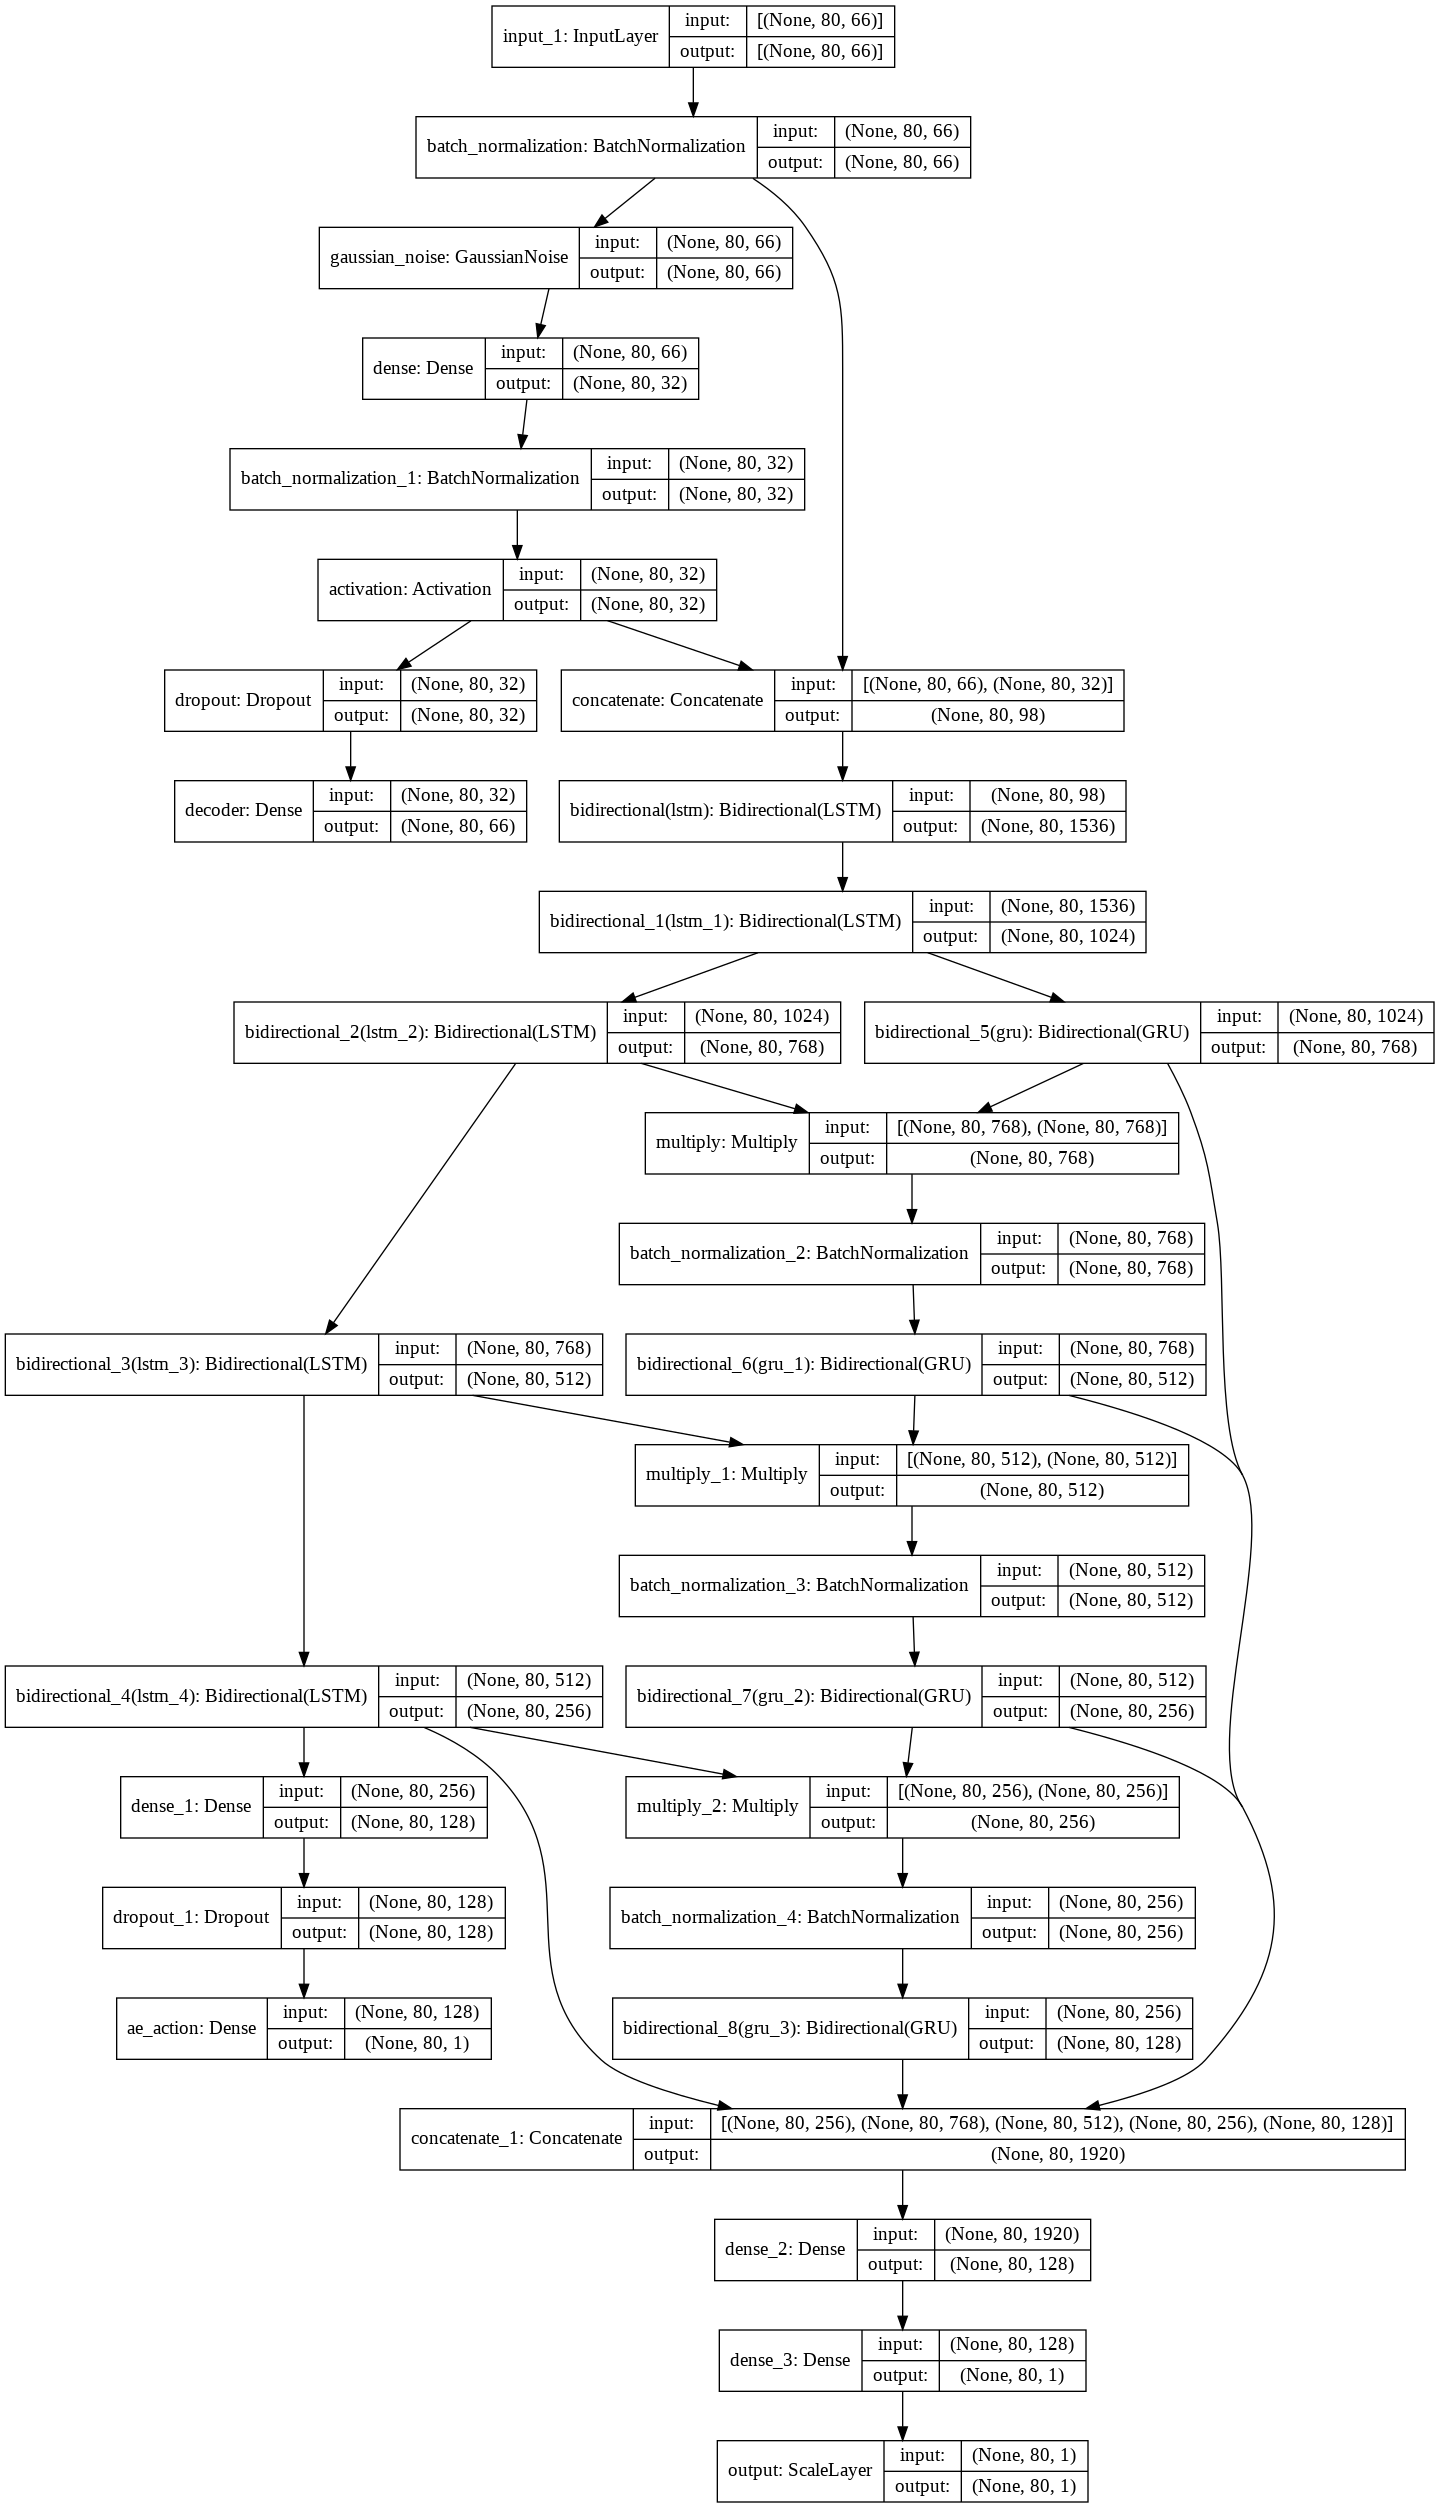

In [25]:
plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)


In [26]:
del model
gc.collect()

35331

In [27]:
#reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
    gc.collect()

reset_keras()

In [28]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

def press_diff(series: np.ndarray):
  return series.diff().abs()


def analy_predict(last_test_idx, train_pred):
  train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
  last_test_breath_ids = train_df['breath_id'].values.reshape(-1, 80)
  last_test_breath_ids = last_test_breath_ids[:, 0]
  last_test_breath_ids = last_test_breath_ids.flatten()
  last_test_breath_ids = last_test_breath_ids[last_test_idx]

  train_pred = train_pred[last_test_idx]
  train_pred = train_pred.flatten()

  train_df = train_df[train_df['breath_id'].isin(last_test_breath_ids)]
  train_df['pred'] = train_pred
  train_df['abs_error'] = np.abs(train_pred-train_df['pressure'])
  train_df['RC'] = train_df["R"].astype(str) + '__' + train_df["C"].astype(str)
  train_df['press_diff'] = train_df.groupby('breath_id')['pressure'].apply(press_diff)

  df_feature = train_df[train_df['u_out']<1].groupby('breath_id').agg({'abs_error': ['mean' , 'max', 'min', 'sum', 'count'], 
                                                                      'RC': ['first'], 
                                                                      'press_diff':['mean', 'max'],
                                                                      'u_in':['first', 'last'],
                                                                      'pressure':['first', 'last', 'mean', 'std']
                                                                      })
  df_feature.columns = ['_'.join(col) for col in df_feature.columns]

  plt.figure(figsize=(16,16))

  plt.title("abs_error distribution by RC")

  for key, grp in df_feature.groupby(['RC_first']):
    print(f'{key} - MAE  {grp.abs_error_mean.mean()}, count: {grp.abs_error_count.sum()}')
    sns.kdeplot(grp['abs_error_mean'], clip=(0.0, 1), 
                label=key)

  plt.axvline(df_feature['abs_error_mean'].mean())
  plt.legend()
  plt.show()



with tpu_strategy.scope():
    skip_folds = np.arange(1)
    VERBOSE = 2
    EPOCHS = 200
    FOLDS = 7
    if DEBUG:
      EPOCHS = 100
    test_preds = []
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2021)
    last_test_idx = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        last_test_idx = test_idx
        if len(test_preds) > fold:
          print(f'Ignore corrent fold {fold+1} as we already predicted test data')

        if DEBUG and fold > 0:
          continue
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model_GaussianNoise()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        checkpoint_name = f'./model-gpu/Bidirect_LSTM_model_{fold+1}C.h5'
        chk_point = ModelCheckpoint(checkpoint_name,
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50,
                           verbose=VERBOSE, mode="min",
                           restore_best_weights=True)
        
        if fold not in skip_folds:
          model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid), 
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    batch_size=BATCH_SIZE, 
                    callbacks=[lr, chk_point, es])
        else:
          print('Load pretrain weight from ', checkpoint_name)
          load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
          try:
            # At loading time, register the custom objects with a `custom_object_scope`:
            custom_objects = {"ScaleLayer": ScaleLayer}
            with tf.keras.utils.custom_object_scope(custom_objects):
                model = load_model(checkpoint_name, options=load_locally)
          except (OSError):
            print('Cannot load pretrain weight from ', checkpoint_name)
            break
                
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        train_pred[test_idx] = y_pred.reshape(-1, 80)
        score = mean_absolute_error(y_true, y_pred)
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        del X_train, X_valid, y_train, y_valid, model
        reset_keras()
        gc.collect()

        analy_predict(test_idx, train_pred)
        break

In [29]:
#skip_folds = np.arange(1)
skip_folds = []
train_pred = np.zeros(targets.shape)

In [ ]:
with tpu_strategy.scope():
    
    VERBOSE = 2
    EPOCHS = 200
    FOLDS = 7
    if DEBUG:
      EPOCHS = 100
    test_preds = []
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2021)
    last_test_idx = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        last_test_idx = test_idx
        if len(test_preds) > fold:
          print(f'Ignore corrent fold {fold+1} as we already predicted test data')

        if DEBUG and fold > 0:
          continue
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model_aen()
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              # loss="mae"
              loss = {'decoder': tf.keras.losses.MeanSquaredError(), 
                  'ae_action': tf.keras.losses.MeanAbsoluteError(),
                  'output': tf.keras.losses.MeanAbsoluteError(), 
                  },
              lossWeights = [1, 1, 1]
              )

        lr = ReduceLROnPlateau(monitor="val_output_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        checkpoint_name = f'./model-gpu/Bidirect_LSTM_model_{fold+1}C.h5'
        chk_point = ModelCheckpoint(checkpoint_name,
                                    monitor='val_output_loss', 
                                    verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_output_loss", patience=50,
                           verbose=VERBOSE, mode="min",
                           restore_best_weights=True)
        
        if fold not in skip_folds:
          model.fit(X_train, [X_train, y_train, y_train], 
                    validation_data=(X_valid, [X_valid, y_valid, y_valid]), 
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    batch_size=BATCH_SIZE, 
                    callbacks=[lr, chk_point, es])
        else:
          print('Load pretrain weight from ', checkpoint_name)
          load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
          try:
            # At loading time, register the custom objects with a `custom_object_scope`:
            custom_objects = {"ScaleLayer": ScaleLayer}
            with tf.keras.utils.custom_object_scope(custom_objects):
                model = load_model(checkpoint_name, options=load_locally)
          except (OSError):
            print('Cannot load pretrain weight from ', checkpoint_name)
            break
                
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE)[-1].squeeze().reshape(-1, 1)
        train_pred[test_idx] = y_pred.reshape(-1, 80)
        score = mean_absolute_error(y_true, y_pred)
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE)[-1].squeeze().reshape(-1, 1).squeeze())

        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        del X_train, X_valid, y_train, y_valid, model
        reset_keras()
        gc.collect()

        analy_predict(test_idx, train_pred)


Epoch 1/200
127/127 - 182s - loss: 114.0473 - decoder_loss: 110.6599 - ae_action_loss: 1.7463 - output_loss: 1.6411 - val_loss: 96.7227 - val_decoder_loss: 93.9187 - val_ae_action_loss: 1.2177 - val_output_loss: 1.5864

Epoch 00001: val_loss improved from inf to 96.72271, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
127/127 - 153s - loss: 93.9851 - decoder_loss: 92.2943 - ae_action_loss: 0.9060 - output_loss: 0.7849 - val_loss: 79.8721 - val_decoder_loss: 77.7617 - val_ae_action_loss: 1.0225 - val_output_loss: 1.0879

Epoch 00002: val_loss improved from 96.72271 to 79.87206, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 3/200
127/127 - 153s - loss: 76.2439 - decoder_loss: 74.7482 - ae_action_loss: 0.8305 - output_loss: 0.6653 - val_loss: 65.9393 - val_decoder_loss: 63.6010 - val_ae_action_loss: 1.0373 - val_output_loss: 1.3010

Epoch 00003: val_loss improved from 79.87206 to 65.93925, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 4/200
127/127 - 153s - loss: 62.1695 - decoder_loss: 60.8210 - ae_action_loss: 0.7411 - output_loss: 0.6075 - val_loss: 52.8784 - val_decoder_loss: 51.5118 - val_ae_action_loss: 0.6146 - val_output_loss: 0.7521

Epoch 00004: val_loss improved from 65.93925 to 52.87843, saving model to ./model-gpu/Bidirect_LSTM_model_1C.h5
Epoch 5/20

with tpu_strategy.scope():
    
    VERBOSE = 2
    EPOCHS = 200
    FOLDS = 7
    if DEBUG:
      EPOCHS = 100
    test_preds = []
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2021)
    last_test_idx = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        last_test_idx = test_idx
        if len(test_preds) > fold:
          print(f'Ignore corrent fold {fold+1} as we already predicted test data')

        if DEBUG and fold > 0:
          continue
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model_GaussianNoise()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        checkpoint_name = f'./model-gpu/Bidirect_LSTM_model_{fold+1}C.h5'
        chk_point = ModelCheckpoint(checkpoint_name,
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50,
                           verbose=VERBOSE, mode="min",
                           restore_best_weights=True)
        
        if fold not in skip_folds:
          model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid), 
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    batch_size=BATCH_SIZE, 
                    callbacks=[lr, chk_point, es])
        else:
          print('Load pretrain weight from ', checkpoint_name)
          load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
          try:
            # At loading time, register the custom objects with a `custom_object_scope`:
            custom_objects = {"ScaleLayer": ScaleLayer}
            with tf.keras.utils.custom_object_scope(custom_objects):
                model = load_model(checkpoint_name, options=load_locally)
          except (OSError):
            print('Cannot load pretrain weight from ', checkpoint_name)
            break
                
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        train_pred[test_idx] = y_pred.reshape(-1, 80)
        score = mean_absolute_error(y_true, y_pred)
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        del X_train, X_valid, y_train, y_valid, model
        reset_keras()
        gc.collect()


In [ ]:
if not DEBUG:
  train_pred = train_pred.flatten()
  targets = targets.flatten()
  score = mean_absolute_error(targets, train_pred)
  print(f"Train Score: {score}")

## Create submission file

In [ ]:
if not DEBUG:
  submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
  submission["pressure"] = sum(test_preds)/5
  submission.to_csv('submission.csv', index=False)

  # ENSEMBLE FOLDS WITH MEDIAN
  #取中位数
  submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
  submission.to_csv('submission_median.csv', index=False)


  # ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
  submission["pressure"] =\
      np.round( (submission.pressure - pressure_min)/pressure_step ) * pressure_step + pressure_min
  submission.pressure = np.clip(submission.pressure, pressure_min, pressure_max)
  submission.to_csv('submission_median_round.csv', index=False)

# Analyze predict data

In [ ]:
analy_predict(last_test_idx, train_pred)